<a href="https://colab.research.google.com/github/tap-o-chek/Multiple-processing-course/blob/main/labs/MP_Lesson_5_%D0%96%D0%B8%D0%B4%D0%B5%D0%BB%D0%B5%D0%B2%D0%B0_%D0%A1%D0%BE%D1%84%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

If you are running on Google Colab, you need to install the necessary dependencies before beginning the exercise.

In [ ]:
print('NOTE: Intentionally crashing session to use the newly installed library.\n')

!pip uninstall -y pyarrow
!pip install ray
!pip install bs4

# A hack to force the runtime to restart, needed to include the above dependencies.
import os
os._exit(0)

NOTE: Intentionally crashing session to use the newly installed library.



# **# Exercise 1 - Simple Parallelization**
**GOAL:** The goal of this exercise is to show how to run simple tasks in parallel.

This script is running too slowly, but the computation is embarrassingly parallel. In this exercise, you will use Ray to execute the functions in parallel to speed it up.

### Introduction to Remote Functions

The `@ray.remote` decorator turns a Python function into a "remote function" that Ray can run in parallel. Here is a simple example:

```python
# A regular Python function.
def regular_function():
    return 1

# A Ray remote function.
@ray.remote
def remote_function():
    return 1
```

There are a few key differences between the original function and the decorated one:

1. **Invocation:** The regular version is called with `regular_function()`, whereas the remote version is called with `remote_function.remote()`.
2. **Return values:** `regular_function` executes synchronously and returns the result of the function (`1`), whereas `remote_function` immediately returns an `ObjectID` (a future) and then executes the task in the background on a separate worker process. The result of the future can be obtained by calling `ray.get` on the `ObjectID`.
    ```python
    >>> regular_function()
    1
    
    >>> remote_function.remote()
    ObjectID(1c80d6937802cd7786ad25e50caf2f023c95e350)
    
    >>> ray.get(remote_function.remote())
    1
    ```
3. **Parallelism:** Invocations of `regular_function` happen **serially**:
    ```python
    # These are executed one at a time, back-to-back.
    result = 0
    for _ in range(4):
        result += regular_function()
    assert result == 4
    ```
    In contrast, invocations of `remote_function` happen in **parallel**:
    ```python
    # Executing these functions happens at the same time in the background, and we get the results using ray.get.
    results = []
    for _ in range(4):
        results.append(remote_function.remote())
    assert sum(ray.get(results)) == 4
    ```

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ray
import time

print('Successfully imported ray!')

Successfully imported ray!


Start the processes that make up the Ray runtime. By default, Ray does not schedule more tasks concurrently than there are CPUs, but this example requires four tasks to run concurrently, so we tell Ray that there are four CPUs. In practice, you would usually just let Ray detect the number of CPUs on the machine.

`ignore_reinit_error=True` just suppresses errors if the cell is run multiple times.

In [ ]:
ray.init(num_cpus=4, ignore_reinit_error=True)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

2024-03-22 13:28:40,443	INFO worker.py:1585 -- Calling ray.init() again after it has already been called.


**EXERCISE:** The loop below takes too long, but the four function calls could be executed in parallel. This should speed up the execution from four seconds to one second.

First, turn `slow_function` into a remote function, then execute the tasks in parallel by calling `slow_function.remote()` and obtaining the results with `ray.get` on the list of returned object IDs.



```python
# A function simulating a more interesting computation that takes one second.
def slow_function(i):
    time.sleep(1)
    return i

start_time = time.time()

results = []
for i in range(4):
  results.append(slow_function(i))

duration = time.time() - start_time
print('Executing the for loop took {:.3f} seconds.'.format(duration))
print('The results are:', results)
print('Run the next cell to check if the exercise was performed correctly.')```



In [ ]:
@ray.remote
def slow_function(i):
    time.sleep(0.5)
    return i

start_time = time.time()

results = []
for i in range(4):
  results.append(slow_function.remote(i))

results = ray.get(results)

duration = time.time() - start_time
print('The results are:', results)
print('Executing the for loop took {:.3f} seconds.'.format(duration))
print('Run the next cell to check if the exercise was performed correctly.')

The results are: [0, 1, 2, 3]
Executing the for loop took 1.041 seconds.
Run the next cell to check if the exercise was performed correctly.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [ ]:
assert results == [0, 1, 2, 3], 'Did you remember to call ray.get?'
assert duration < 1.1, ('The loop took {:.3f} seconds. This is too slow.'
                        .format(duration))
assert duration > 1, ('The loop took {:.3f} seconds. This is too fast.'
                      .format(duration))

print('Success! The example took {} seconds.'.format(duration))

Success! The example took 1.0414865016937256 seconds.


**EXERCISE:** Use the UI to view the task timeline and to verify that the four tasks were executed in parallel. You can do this as follows.

1. Run the following cell to generate a JSON file containing the profiling data.
2. Download the timeline file by right clicking on `exercise_1.json` in the **Files** tab in the navigator to the left, right clicking, and selecting  **"Download"**.
3. Enter **chrome://tracing** into the Chrome web browser, click on the **"Load"** button, and select the downloaded JSON file.

To navigate within the timeline:
- Move around by clicking and dragging.
- Zoom in and out by holding **alt** on Windows or **option** on Mac and scrolling.

**NOTE:** The timeline visualization will only work in **Chrome**.

In [ ]:
ray.timeline(filename="exercise_1.json")

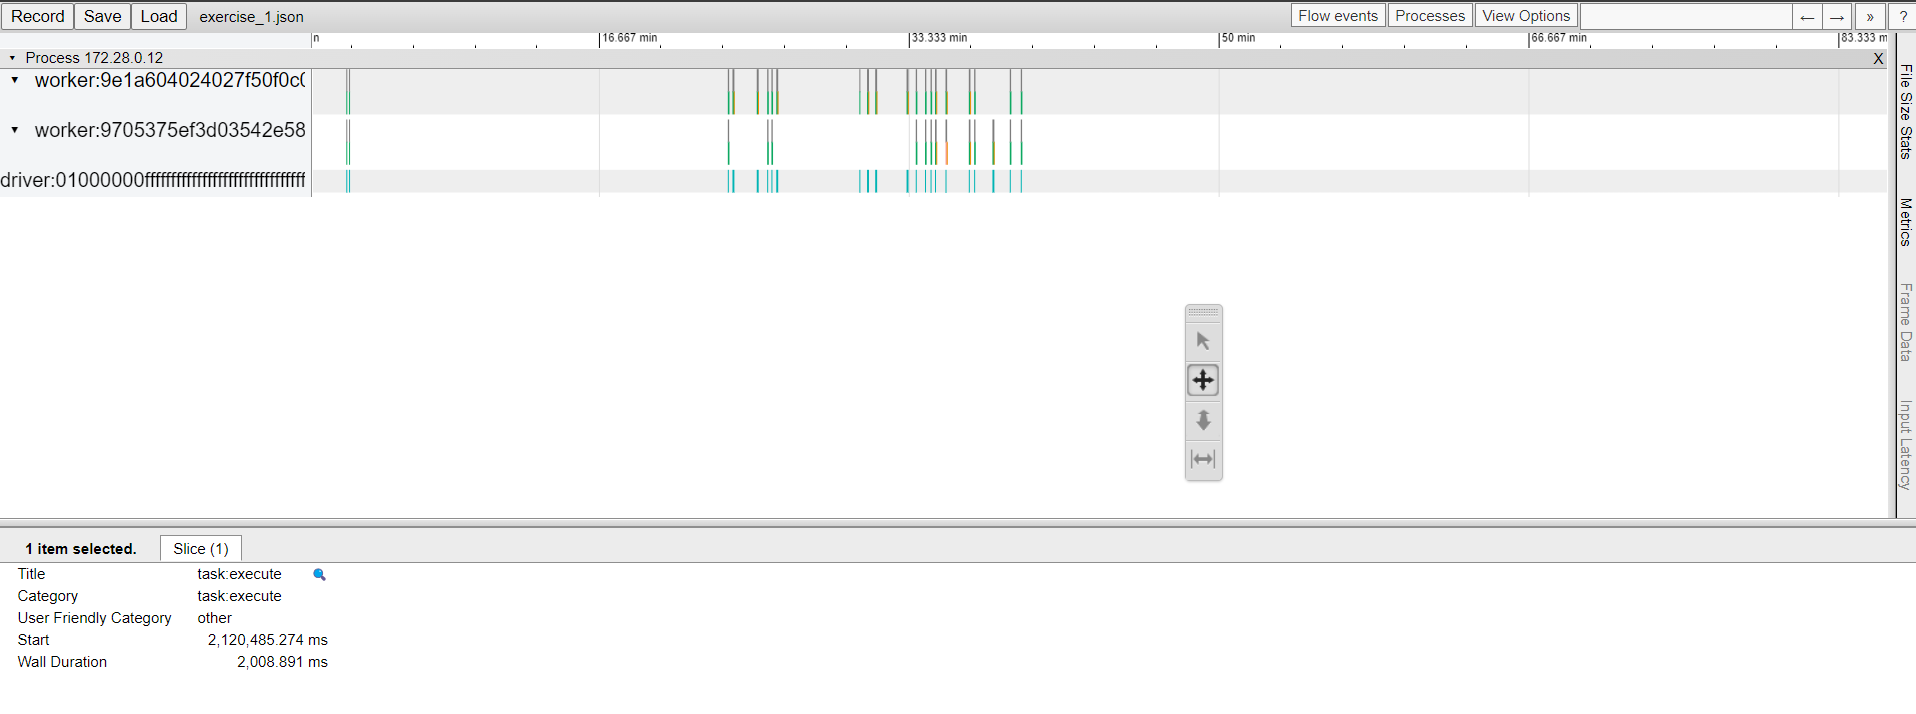

# Exercise 2 - Parallel Data Processing with Task Dependencies

**GOAL:** The goal of this exercise is to pass object IDs into remote functions to encode dependencies between tasks.

In this exercise, we construct a sequence of tasks, each of which depends on the previous, mimicking a data parallel application. Within each sequence, tasks are executed serially, but multiple sequences of tasks can be executed in parallel. You will use Ray to speed up the computation by parallelizing the sequences.

### Concept for this Exercise - Task Dependencies

Consider the following basic remote function that returns the argument passed to it. If we pass in some normal Python objects, the results returned by `ray.get` should be the same objects.

```python
@ray.remote
def f(x):
    return x

>>> x1_id = f.remote(1)
>>> ray.get(x1_id)
1

>>> x2_id = f.remote([1, 2, 3])
>>> ray.get(x2_id)
[1, 2, 3]
```

However, **object IDs** can also be passed into remote functions. When the function is executed, Ray will automatically substitute the underlying Python object that the object ID refers to. In a sense, it's the same as calling `ray.get` on each argument that's passed in as an argument.

```python
>>> y1_id = f.remote(x1_id)
>>> ray.get(y1_id)
1

>>> y2_id = f.remote(x2_id)
>>> ray.get(y2_id)
[1, 2, 3]
```

When implementing a remote function, the function should expect a regular Python object regardless of whether the caller passes in a regular Python object or an object ID.

**These task dependencies affect scheduling.** In the example above, the task that creates `y1_id` depends on the task that creates `x1_id`. This means that:

- The second task will not be executed until the first task has finished executing.
- If the two tasks are scheduled on different machines, the output of the first task (the value corresponding to `x1_id`) will be copied over the network to the machine where the second task is scheduled.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time

import ray

In [ ]:
ray.init(num_cpus=4, ignore_reinit_error=True)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

2024-03-28 11:34:38,050	INFO worker.py:1752 -- Started a local Ray instance.


**EXERCISE:** Below are some helper functions that mimic the pattern of a data parallel application that we want to speed up. To do so, you'll need to turn all of these functions into remote functions. Remember that you don't need to worry about whether the caller passes in an object ID or a regular object, because in both cases the arguments will be regular objects when the function executes. This means that even if you pass in an object ID, you **do not need to call `ray.get`** inside of these remote functions.

In [ ]:
@ray.remote
def load_data(filename):
    time.sleep(0.1)
    return np.ones((1000, 100))

@ray.remote
def normalize_data(data):
    time.sleep(0.1)
    return data - np.mean(data, axis=0)

@ray.remote
def extract_features(normalized_data):
    time.sleep(0.1)
    return np.hstack([normalized_data, normalized_data ** 2])

@ray.remote
def compute_loss(features):
    num_data, dim = features.shape
    time.sleep(0.1)
    return np.sum((np.dot(features, np.ones(dim)) - np.ones(num_data)) ** 2)

assert hasattr(load_data, 'remote'), 'load_data must be a remote function'
assert hasattr(normalize_data, 'remote'), 'normalize_data must be a remote function'
assert hasattr(extract_features, 'remote'), 'extract_features must be a remote function'
assert hasattr(compute_loss, 'remote'), 'compute_loss must be a remote function'

**EXERCISE:** The loop below takes too long. Parallelize the four passes through the loop by turning `load_data`, `normalize_data`, `extract_features`, and `compute_loss` into remote functions and then retrieving the losses with `ray.get`.

**NOTE:** You should only use **ONE** call to `ray.get`. For example, the object ID returned by `load_data` should be passed directly into `normalize_data` without needing to be retrieved by the driver.

In [ ]:
start_time = time.time()
losses = []
for filename in ['file1', 'file2', 'file3', 'file4']:
    inner_start = time.time()

    data = load_data.remote(filename)
    normalized_data = normalize_data.remote(data)
    features = extract_features.remote(normalized_data)
    loss = compute_loss.remote(features)
    losses.append(loss)

    inner_end = time.time()

    if inner_end - inner_start >= 0.1:
        raise Exception('You may be calling ray.get inside of the for loop! '
                        'Doing this will prevent parallelism from being exposed. '
                        'Make sure to only call ray.get once outside of the for loop.')

print('The losses are {}.'.format(ray.get(losses)) + '\n')
loss = sum(ray.get(losses))

duration = time.time() - start_time

print('The loss is {}. This took {:.3f} seconds. Run the next cell to see '
      'if the exercise was done correctly.'.format(loss, duration))

The losses are [1000.0, 1000.0, 1000.0, 1000.0].

The loss is 4000.0. This took 0.480 seconds. Run the next cell to see if the exercise was done correctly.


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

In [ ]:
assert loss == 4000
assert duration < 0.8, ('The loop took {:.3f} seconds. This is too slow.'
                        .format(duration))
assert duration > 0.4, ('The loop took {:.3f} seconds. This is too fast.'
                        .format(duration))

print('Success! The example took {:.3f} seconds.'.format(duration))

Success! The example took 0.480 seconds.


**EXERCISE:** Use the UI to view the task timeline and to verify that the four tasks were executed in parallel. You can do this as follows.

1. Run the following cell to generate a JSON file containing the profiling data.
2. Download the timeline file by right clicking on `exercise_2.json` in the **Files** tab in the navigator to the left, right clicking, and selecting  **"Download"**.
3. Enter **chrome://tracing** into the Chrome web browser, click on the **"Load"** button, and select the downloaded JSON file.

To navigate within the timeline:
- Move around by clicking and dragging.
- Zoom in and out by holding **alt** on Windows or **option** on Mac and scrolling.

**NOTE:** The timeline visualization will only work in **Chrome**.

In [ ]:
ray.timeline(filename="exercise_2.json")

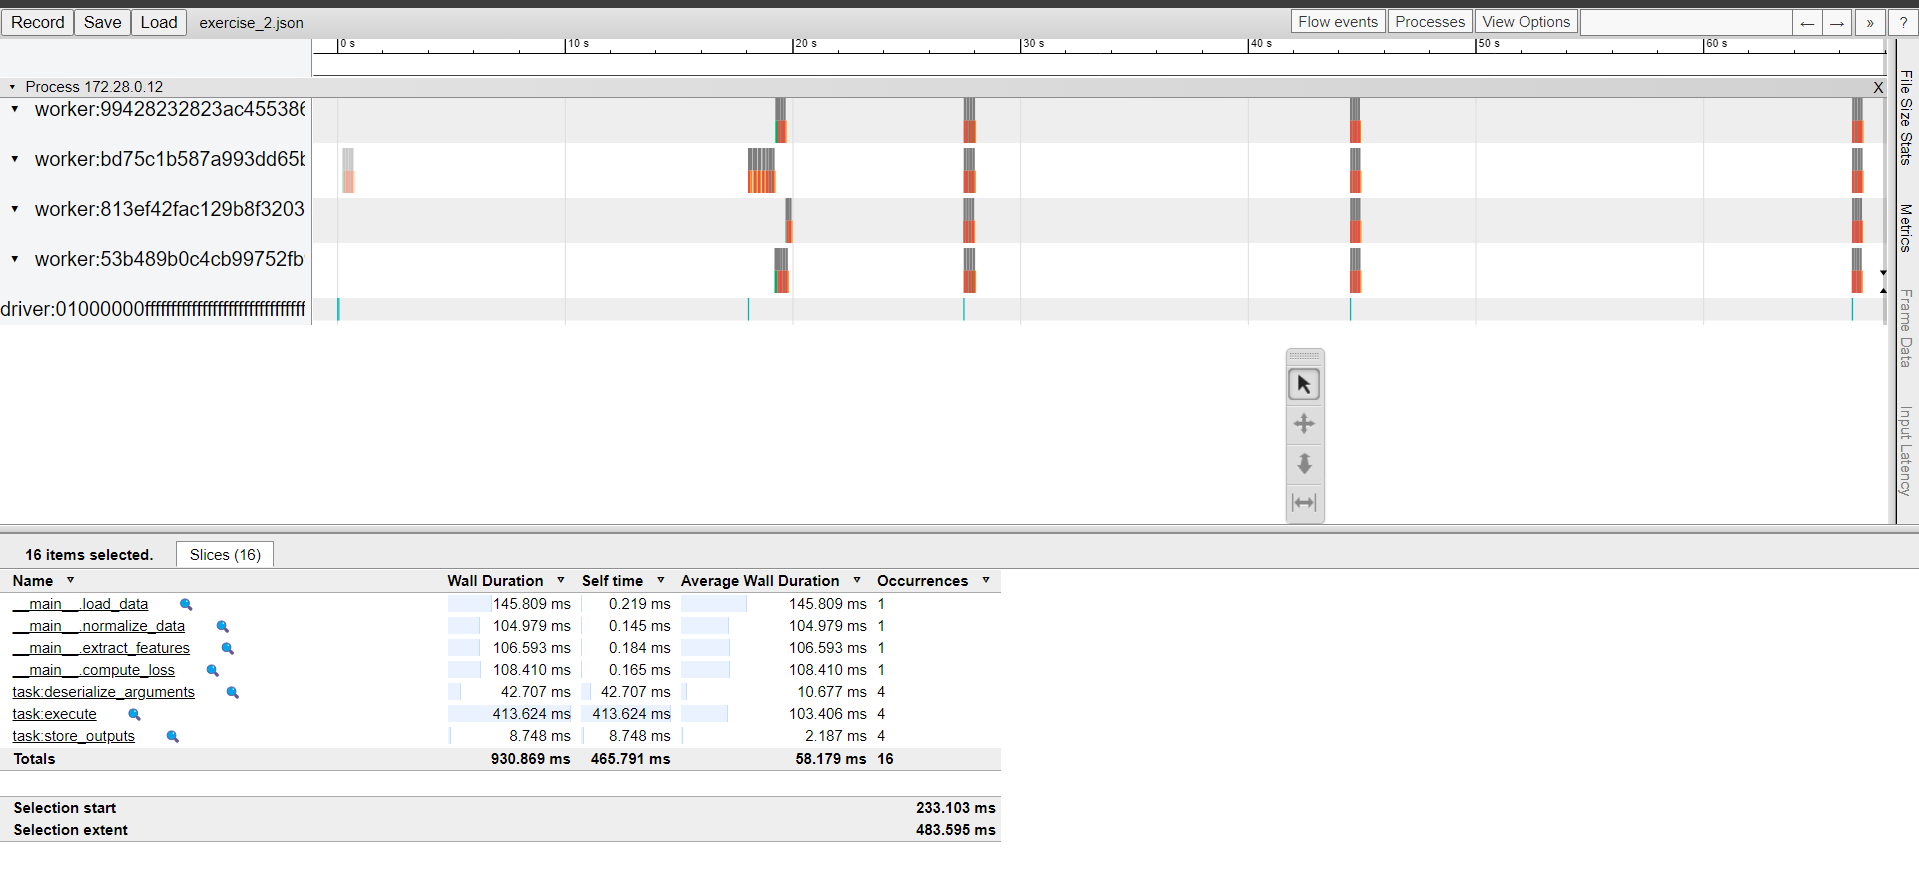

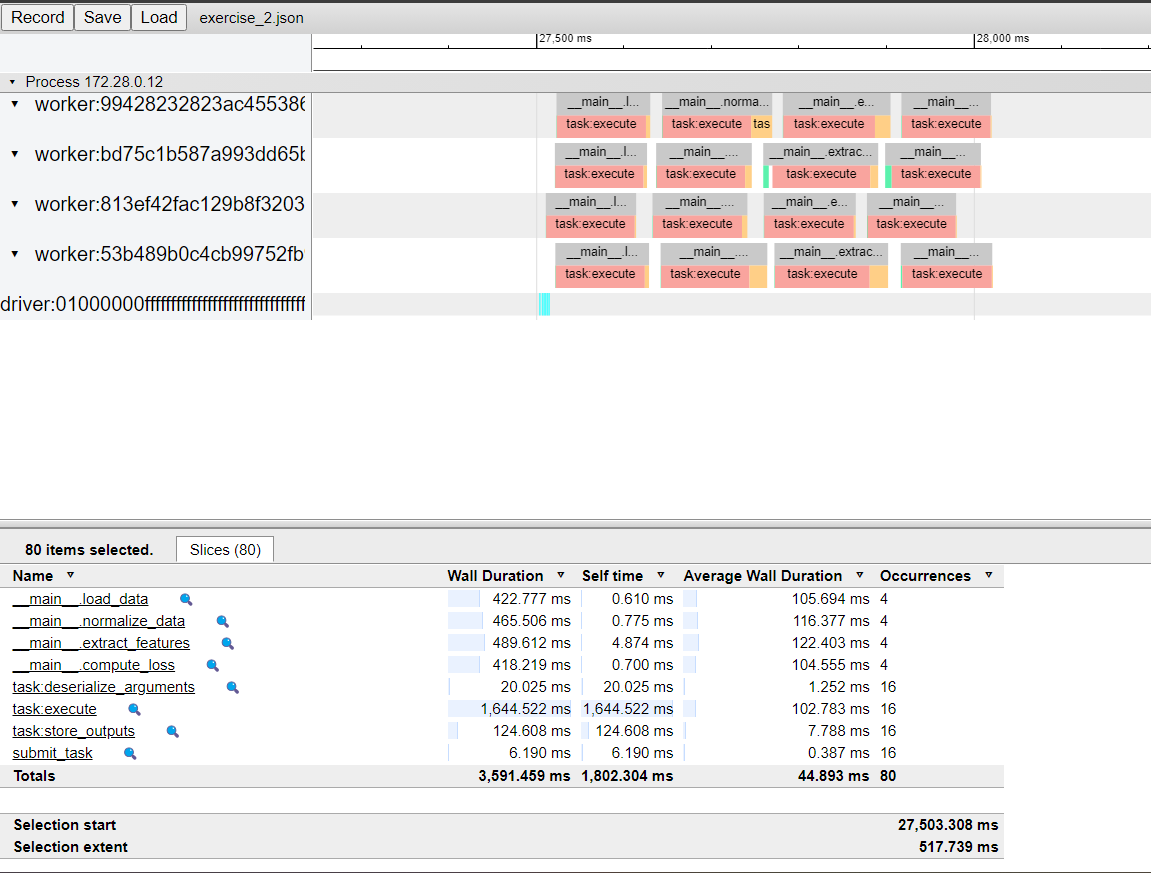

### Application: Parallel web-scraping

One useful application of what we have learned so far is to scrape information from the web. We will illustrate this in a toy setting, but the same principles apply on a large scale where crawling through websites, parsing them and extracting useful content (e.g. for building a search index or populating a database) is often very computationally demanding.

We break up the process into multiple steps. We first grab the raw HTML of the website using Python's requests package. Then, we use BeautifulSoup to parse the HTML to find the relevant information. Finally, we populate a pandas DataFrames so that we are able to work with the data.

To demonstrate this, we scrape GitHub commits to see the latest commits on several repositories.

In [ ]:
from bs4 import BeautifulSoup
import requests

import pandas as pd

The following function uses these libraries to parse the latest commits from several repositories on GitHub.

In [ ]:
@ray.remote
def fetch_commits(repo):
    url = 'https://github.com/{}/commits/master'.format(repo)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    df = pd.DataFrame(columns=['title', 'link'])
    for g in soup.find_all(class_='commit-title'):
        entry = {}
        title = g.find_all(class_='message')[0]['aria-label']
        entry['title'] = title
        links = g.find_all(class_='issue-link')
        if len(links) >= 1:
            link = links[0]['data-url']
            entry['link'] = link
        df = df.append(pd.DataFrame(entry, index=[0]), sort=False)

    df['repository'] = repo
    return df

Let's try this out to get results for some ray related topics serially.

In [ ]:
start = time.time()
repos = ["ray-project/ray", "modin-project/modin", "tensorflow/tensorflow", "apache/arrow"]
results = []
for repo in repos:
    df = fetch_commits.remote(repo)
    results.append(df)

df = pd.concat(ray.get(results), sort=False)
duration = time.time() - start
print("Constructing the dataframe took {:.3f} seconds.".format(duration))

Constructing the dataframe took 0.634 seconds.


**EXERCISE**: Speed up the above serial query by making `fetch_commits` a remote function in order to scrape GitHub results in parallel. Then, see a sample of the data scraped below and feel free to play with the data to find other resources to learn more about these libraries!

In [ ]:
df

,title,link,repository


No charts were generated by quickchart


# Exercise 3 - Nested Parallelism

**GOAL:** The goal of this exercise is to show how to create nested tasks by calling a remote function inside of another remote function.

In this exercise, you will implement the structure of a parallel hyperparameter sweep which trains a number of models in parallel. Each model will be trained using parallel gradient computations.

### Concepts for this Exercise - Nested Remote Functions

Remote functions can call other functions. For example, consider the following.

```python
@ray.remote
def f():
    return 1

@ray.remote
def g():
    # Call f 4 times and return the resulting object IDs.
    results = []
    for _ in range(4):
      results.append(f.remote())
    return results

@ray.remote
def h():
    # Call f 4 times, block until those 4 tasks finish,
    # retrieve the results, and return the values.
    results = []
    for _ in range(4):
      results.append(f.remote())
    return ray.get(results)
```

Then calling `g` and `h` produces the following behavior.

```python
>>> ray.get(g.remote())
[ObjectID(b1457ba0911ae84989aae86f89409e953dd9a80e),
 ObjectID(7c14a1d13a56d8dc01e800761a66f09201104275),
 ObjectID(99763728ffc1a2c0766a2000ebabded52514e9a6),
 ObjectID(9c2f372e1933b04b2936bb6f58161285829b9914)]

>>> ray.get(h.remote())
[1, 1, 1, 1]
```

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import time

import ray

In [ ]:
ray.init(num_cpus=9, ignore_reinit_error=True)

# Sleep a little to improve the accuracy of the timing measurements used below,
# because some workers may still be starting up in the background.
time.sleep(2.0)

2024-03-28 12:25:24,206	INFO worker.py:1752 -- Started a local Ray instance.


This example represents a hyperparameter sweep in which multiple models are trained in parallel. Each model training task also performs data parallel gradient computations.

**EXERCISE:** Turn `compute_gradient` and `train_model` into remote functions so that they can be executed in parallel. Inside of `train_model`, do the calls to `compute_gradient` in parallel and fetch the results using `ray.get`.

In [ ]:
@ray.remote
def compute_gradient(data, current_model):
    time.sleep(0.03)
    return 1

@ray.remote
def train_model(hyperparameters):
    current_model = 0
    # Iteratively improve the current model. This outer loop cannot be parallelized.
    for _ in range(10):
        # EXERCISE: Parallelize computing the gradients below. Note that we still need
        # to get all of the results in order to compute the updated model (by taking
        # the sum), so it's ok to call ray.get() inside of the loop here.
        gradients = []
        for j in range(2):
            gradients.append(compute_gradient.remote(j, current_model))
        current_model += sum(ray.get(gradients))

    return current_model

assert hasattr(compute_gradient, 'remote'), 'compute_gradient must be a remote function'
assert hasattr(train_model, 'remote'), 'train_model must be a remote function'

**EXERCISE:** The code below runs 3 hyperparameter experiments. Change this to run the experiments in parallel.

In [ ]:
# Sleep a little to improve the accuracy of the timing measurements below.
time.sleep(2.0)
start_time = time.time()

# Run some hyperparameter experiments.
results = []
for hyperparameters in [{'learning_rate': 1e-1, 'batch_size': 100},
                        {'learning_rate': 1e-2, 'batch_size': 100},
                        {'learning_rate': 1e-3, 'batch_size': 100}]:
    results.append(train_model.remote(hyperparameters))


# EXERCISE: Once you've turned "results" into a list of Ray ObjectIDs
# by calling train_model.remote, you will need to turn "results" back
# into a list of integers, e.g., by doing "results = ray.get(results)".

results = ray.get(results)

end_time = time.time()
duration = end_time - start_time

assert all([isinstance(x, int) for x in results]), \
    'Looks like "results" is {}. You may have forgotten to call ray.get.'.format(results)

(raylet) WARNING: 8 PYTHON worker processes have been started on node: 712e884bdbed641bdfbe49424f0d98871fe2b99be9bfa5f7d907722e with address: 172.28.0.12. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


**VERIFY:** Run some checks to verify that the changes you made to the code were correct. Some of the checks should fail when you initially run the cells. After completing the exercises, the checks should pass.

**NOTE:** This exercise is known to have issues running on remote notebooks that can be resolved by rerunning the above cell a second time.

In [ ]:
assert results == [20, 20, 20]
assert duration < 0.5, ('The experiments ran in {:.3f} seconds. This is too '
                         'slow.'.format(duration))
assert duration > 0.3, ('The experiments ran in {:.3f} seconds. This is too '
                        'fast.'.format(duration))

print('Success! The example took {:.3f} seconds.'.format(duration))

AssertionError: The experiments ran in 3.425 seconds. This is too slow.

**EXERCISE:** Use the UI to view the task timeline and to verify that the four tasks were executed in parallel. You can do this as follows.

1. Run the following cell to generate a JSON file containing the profiling data.
2. Download the timeline file by right clicking on `exercise_3.json` in the **Files** tab in the navigator to the left, right clicking, and selecting  **"Download"**.
3. Enter **chrome://tracing** into the Chrome web browser, click on the **"Load"** button, and select the downloaded JSON file.

To navigate within the timeline:
- Move around by clicking and dragging.
- Zoom in and out by holding **alt** on Windows or **option** on Mac and scrolling.

**NOTE:** The timeline visualization will only work in **Chrome**.

In [ ]:
ray.timeline(filename="exercise_3.json")

Ассерт по времени не проходит, хотя по трекеру всё в порядке. С каждым перезапуском время скачет: то 1.3сек, то 8сек, то 3.8.....

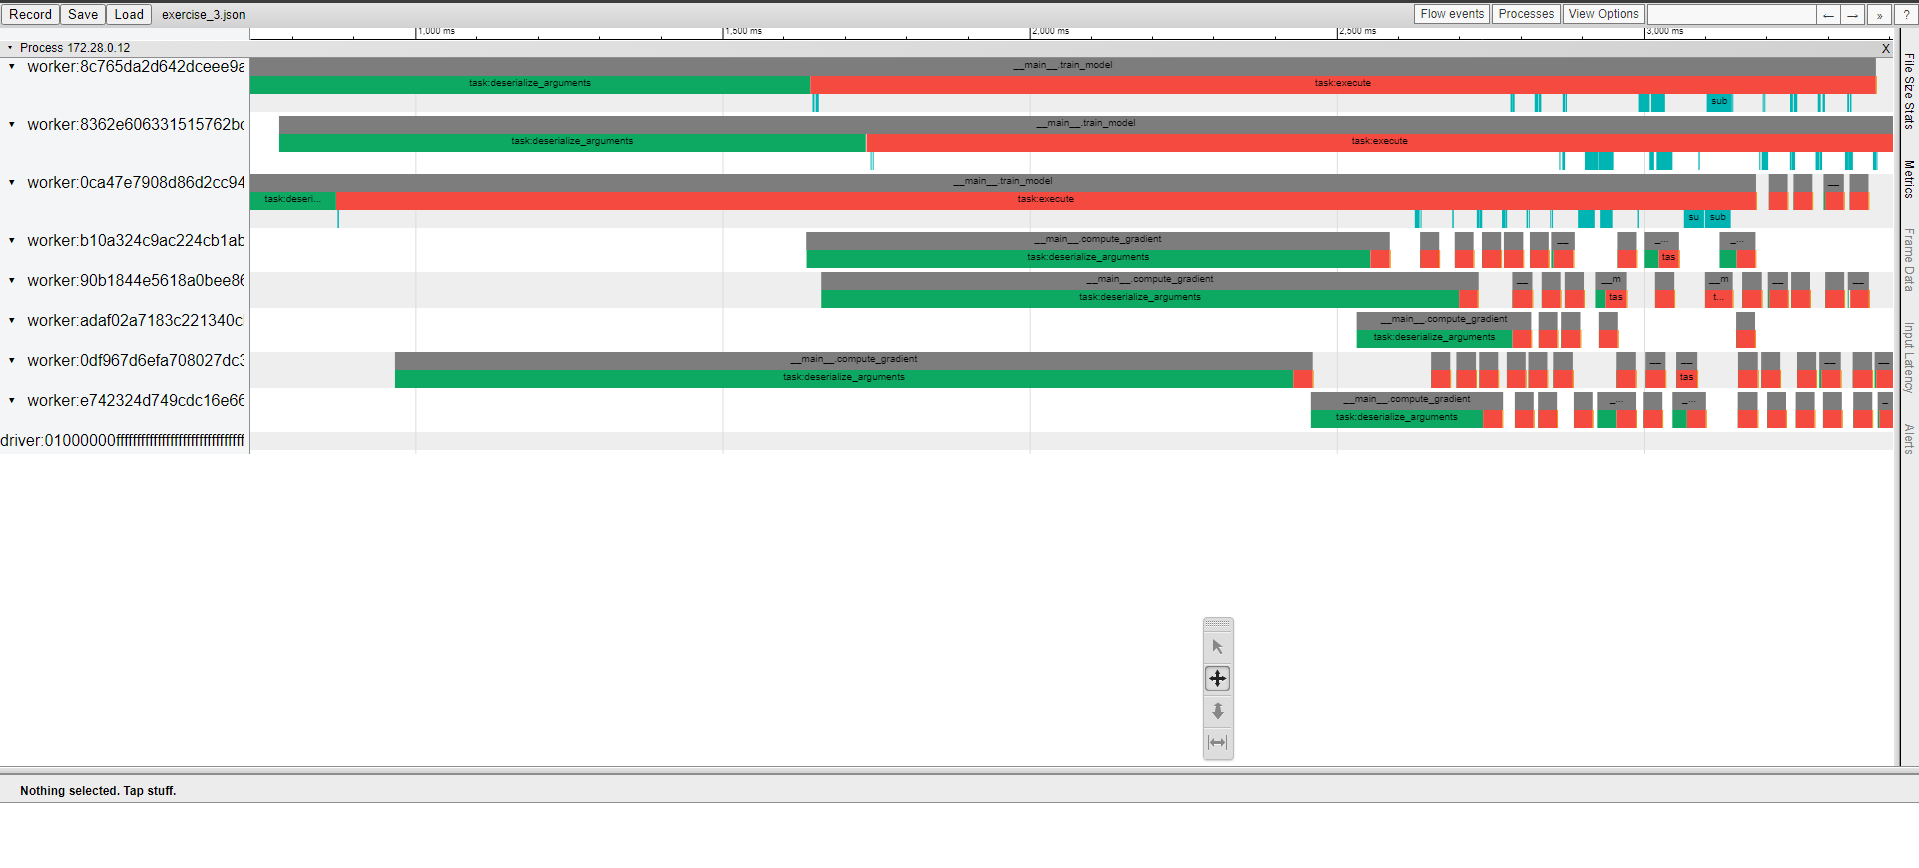

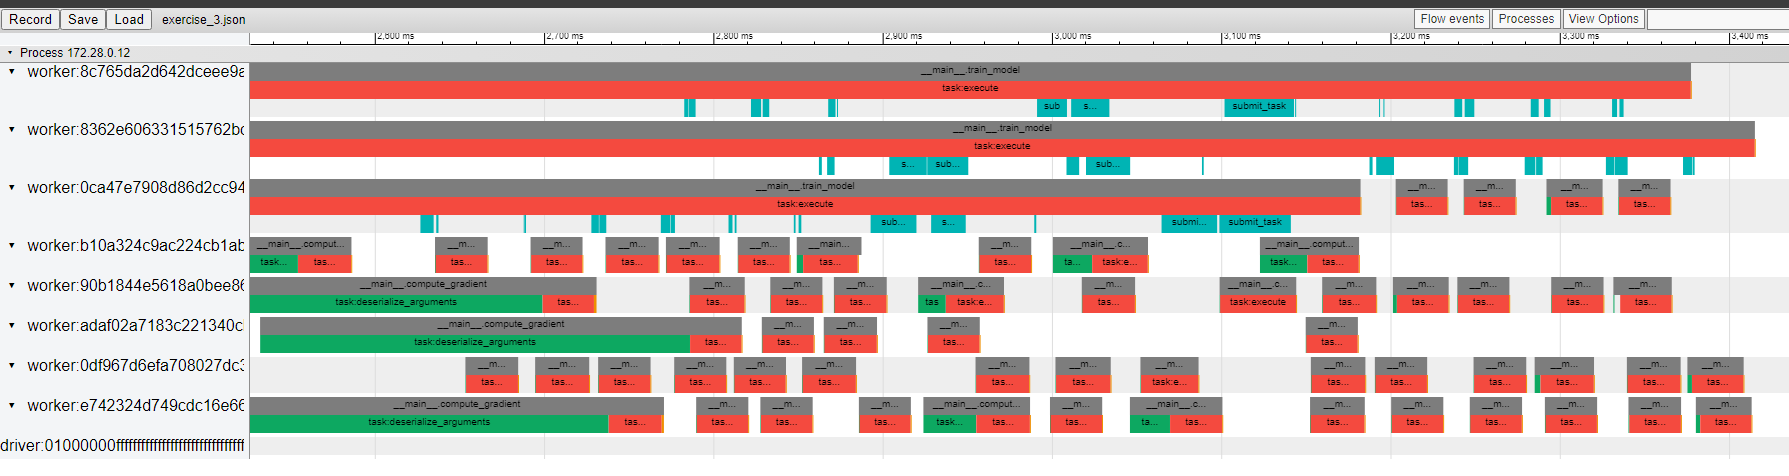